<a href="https://colab.research.google.com/github/diego200052/Aprendizaje-Profundo-Tarea01-MMDR/blob/master/Ejercicio%203%20MMDR.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. Regresión lineal con PyTorch
Entrena y evalúa un modelo de regresión lineal para el conjunto de datos de calificaciones que
considere los dos atributos de entrada.

Especificaciones:
- Grafica los datos en 3D.
- Realiza la definición de la arquitectura usando tanto la interfaz de alto como la de medio
nivel.
- Prueba distintos valores para los hiperparámetros.
- Realiza una predicción con tu modelo entrenado para la calificación que tendría un
alumno si sabemos que estudió durante 12 horas para el examen y en un examen previo
obtuvo 3 de calificación.
- Discute las modificaciones que realizaste y las distintas configuraciones para los hiperparámetros
que probaste.

Primeramente se importan las bibliotecas necesarias para ejecutar la libreta.

In [ ]:
# Carga de bibliotecas
import os
import math
import random

# Tomar n elementos de una secuencia
from itertools import islice as take

# Biblioteca para graficar
import matplotlib.pyplot as plt
# Modo 3D
from mpl_toolkits import mplot3d

# Matrices
import numpy as np
import pandas as pd

# Redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
# Carga de datos
from torch.utils.data import DataLoader, TensorDataset

Después, se establecen las variables que contienen la ubicación de los datos en formato CSV, así como en que directorio local se deberá almacenar.

In [ ]:
# Variables de acceso a los datos
URL = 'https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2023-1/data/califs/califs.csv'
data_dir = '../data'
filepath = os.path.join(data_dir, 'califs.csv')

def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

Se crea el directorio y se almacena el archivo CSV con los datos, posteriormente se carga como un dataframe de pandas.

In [ ]:
# Comandos de la terminal de linux para crear la carpeta y descargar el archivo CSV.
! mkdir {data_dir}
! wget -nc {URL} -O {filepath}

# Cargar los datos desde un archivo CSV hacia un dataframe de pandas.
df = pd.read_csv(filepath)
# Mostrar algunas métricas de los datos.
df.describe()

mkdir: cannot create directory ‘../data’: File exists
File ‘../data/califs.csv’ already there; not retrieving.


,prev,horas,calif
count,50.000000,50.000000,50.000000
mean,6.750000,12.006000,7.292000
std,1.175125,1.293691,0.924903
min,4.200000,8.200000,5.100000
25%,5.900000,11.350000,6.700000
50%,6.700000,11.900000,7.250000
75%,7.450000,12.900000,7.875000
max,10.100000,14.400000,9.200000


In [ ]:
# Muestra la cabeza del dataframe
df.head()

,prev,horas,calif
0,5.6,8.2,5.1
1,6.7,9.3,5.9
2,5.1,10.0,5.4
3,5.7,10.4,6.5
4,7.1,10.4,6.7


### Gráfica de los datos en 3D

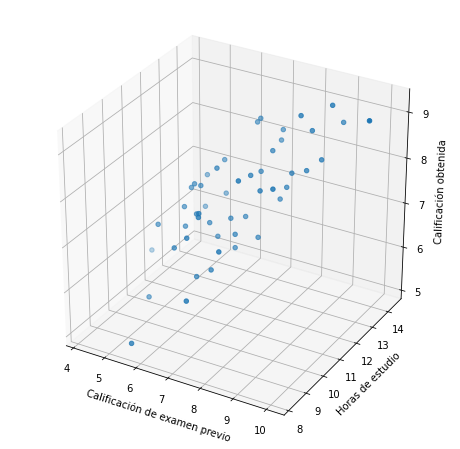

In [ ]:
# Se inicializa un objeto para graficar en 3D.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

# Se obtiene el primer atributo de entrada
x = np.array(df.iloc[:,0], dtype='float32')
# Se obtiene el segundo atributo de entrada
y = np.array(df.iloc[:,1], dtype='float32')
# Se obtiene la salda
z = np.array(df.iloc[:,-1], dtype='float32')

ax.set_xlabel("Calificación de examen previo")
ax.set_ylabel("Horas de estudio")
ax.set_zlabel("Calificación obtenida")
ax.scatter3D(x, y, z, cmap='Blues')

### Carga de datos

In [ ]:
x_trn = np.array(df.iloc[:,:2], dtype="float32")
y_trn = np.array(df.iloc[:,-1], dtype="float32")[..., np.newaxis]

x_trn = torch.tensor(x_trn)
y_trn = torch.tensor(y_trn)

# Forma de la entrada
print(x_trn.shape)
# Forma de la salida
print(y_trn.shape)

# Carga el conjunto de datos en un tensor de pytorch
ds = TensorDataset(x_trn, y_trn)
# Tensores de la primer muestra de datos
print(ds[0])
print(len(ds))

torch.Size([50, 2])
torch.Size([50, 1])
(tensor([5.6000, 8.2000]), tensor([5.1000]))
50


Se define la función que construye lotes de tamaño a lo más 16 dado el conjunto de datos en forma de TensorDataset.

In [ ]:
# Función que crea un DataLoader con lotes de a lo más 16 elementos (por defecto)
def build_dl(batch_size=16, shuffle=True):
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

Como es una regresión lineal para el cálculo de la pérdida se utiliza la función del error cuadrático medio.

$$
ECM(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^n (y^{(i)}-\hat{y}^{(i)})^{2}
$$

### Función de entrenamiento por época

In [ ]:
def train_epoch(dl, model, opt):
       
    # Entrenamiento de una época por cada lote de a lo más 16 elementos
    for x, y_true in dl:

        # Se hace inferencia para obtener los logits
        y_lgts = model(x)
        
        # Se calcula la pérdida (Error cuadrático medio)
        loss = nn.functional.mse_loss(y_lgts, y_true)
        
        # Se limpian los gradientes
        opt.zero_grad()
        
        # Retropropagación
        loss.backward()
        
        # Se actualizan los parámetros
        opt.step()

### Función de validación por época

In [ ]:
def eval_epoch(dl, model, num_batches=None):

    # Se evita el registro de las operaciones en la gráfica de cómputo
    with torch.no_grad():

        # Historial de pérdidas
        losses = []

        # Si no se especifica num_batches entonces
        # el for itera sobre todos los lotes de a lo
        # más 16 elementos.
        for x, y_true in take(dl, num_batches):

            # Se calculan los logits
            y_lgts = model(x)

            # Se calcula la pérdida
            loss = nn.functional.mse_loss(y_lgts, y_true)

            # Se guarda la pérdida
            losses.append(loss.item() * 100)

        # Se promedian las pérdiads
        loss = np.mean(losses)

        return loss

### Función de entrenamiento del modelo

In [ ]:
def train(model, dl, epochs=5, lr=1e-3, num_batches=None):
    
    # Historial de pérdida
    loss_hist = []

    # Como optimizador se usa el descenso por gradiente estocástico (con momento)
    opt = optim.SGD(model.parameters(), lr=lr)

    # Ciclo de entrenamiento
    for epoch in range(epochs):
        
        # Se entrena la época
        train_epoch(dl, model, opt)
        
        # Se evalúa la época
        trn_loss = eval_epoch(dl, model, num_batches=num_batches)

        # Se guarda la pérdida en esa época
        loss_hist.append([trn_loss])

        # Se imprime el progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f}]')
        
    #Regresa el historial de pérdidas y exactitudes
    return loss_hist

# Función principal que entrena el modelo 
def train_model(build_model, epochs=5, lr=1e-3, num_neuronas = 5, num_batches=None):
    set_seed()
    dl = build_dl()
    model = build_model(num_neuronas)
    print(model)
    loss_hist = train(model, dl, epochs=epochs, lr=lr, num_batches=num_batches)
    return model, loss_hist

### Definición de la arquitectura de alto nivel

In [ ]:
def build_high(num_neuronas = 5):
    # Se define la arquitectura empleando la clase Sequential y apilando las capas
    model = nn.Sequential(
        nn.Linear(2, num_neuronas),
        nn.ReLU(),
        nn.Linear(num_neuronas, 1),
    )
    return model

build_high()

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

### Definición de la arquitectura de medio nivel

In [ ]:
# Se define la clase RegLin que hereda de torch.nn.Module
class LinRegMed(nn.Module):

    # Se define el inicializador
    def __init__(self, num_neuronas):
        # Se llama al inicializador de la clase padre
        super().__init__()
        # Se definen las capas como atributos de la clase
        self.fc1 = nn.Linear(2, num_neuronas)
        self.fc2 = nn.Linear(num_neuronas, 1)

    # Método para realizar la inferencia
    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

def build_med(num_neuronas = 5):
    return LinRegMed(num_neuronas)

build_med()

LinRegMed(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

### Entrenamiento con arquitectura de alto nivel

In [ ]:
model_high, loss_hist = train_model(build_high, epochs=5, lr=0.001, num_neuronas = 2)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)
E00 loss=[3661.86]
E01 loss=[1171.65]
E02 loss=[109.31]
E03 loss=[ 22.81]
E04 loss=[ 15.75]


#### Resultados

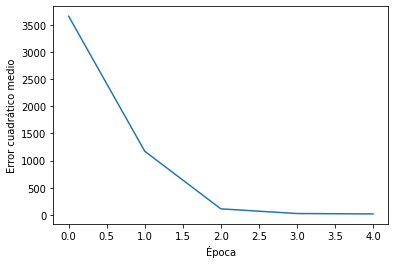

In [ ]:
plt.plot(loss_hist)
plt.xlabel(u'Época')
plt.ylabel(u'Error cuadrático medio')
plt.show()

### Predicción con arquitectura de alto nivel

In [ ]:
with torch.no_grad():
    x = torch.Tensor([3, 12])
    y_lgts = model_high(x)
    print(f"Para un alumno con calificación previa de {x[0]} y horas de estudio {x[1]}, el modelo predice que la calificación que obtendrá es: {y_lgts[0]:.2f}.")

Para un alumno con calificación previa de 3.0 y horas de estudio 12.0, el modelo predice que la calificación que obtendrá es: 6.74.


### Entrenamiento con arquitectura de medio nivel

In [ ]:
model_med, loss_hist = train_model(build_med, epochs=5, lr=0.001, num_neuronas = 2)

LinRegMed(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)
E00 loss=[3661.86]
E01 loss=[1171.65]
E02 loss=[109.31]
E03 loss=[ 22.81]
E04 loss=[ 15.75]


#### Resultados

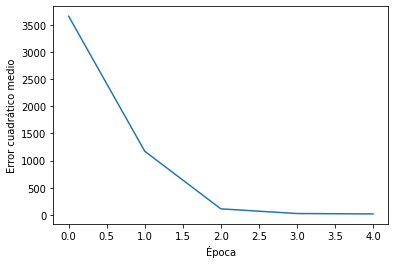

In [ ]:
plt.plot(loss_hist)
plt.xlabel(u'Época')
plt.ylabel(u'Error cuadrático medio')
plt.show()

### Prueba con distintos hiperparámetros

#### Disminuir la tasa de aprendizaje, aumentar el número de épocas y mantener número de neuronas en la capa oculta.
Tasa de aprendizaje $\alpha = 0.0001$, número de épocas $= 50$ y número de neuronas en la capa oculta $= 2$.

In [ ]:
model_high, loss_hist = train_model(build_high, epochs=50, lr=0.0001, num_neuronas = 2)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)
E00 loss=[5360.34]
E01 loss=[5180.57]
E02 loss=[5018.24]
E03 loss=[5144.60]
E04 loss=[4963.74]
E05 loss=[4535.20]
E06 loss=[4298.83]
E07 loss=[4311.34]
E08 loss=[3852.80]
E09 loss=[3632.21]
E10 loss=[3894.08]
E11 loss=[3255.02]
E12 loss=[2900.66]
E13 loss=[2829.31]
E14 loss=[2448.48]
E15 loss=[1959.61]
E16 loss=[1920.43]
E17 loss=[1674.48]
E18 loss=[1388.48]
E19 loss=[1139.06]
E20 loss=[985.34]
E21 loss=[748.70]
E22 loss=[669.96]
E23 loss=[527.26]
E24 loss=[438.87]
E25 loss=[320.99]
E26 loss=[237.61]
E27 loss=[192.35]
E28 loss=[151.71]
E29 loss=[119.76]
E30 loss=[ 95.44]
E31 loss=[ 78.35]
E32 loss=[ 62.34]
E33 loss=[ 53.38]
E34 loss=[ 40.49]
E35 loss=[ 33.85]
E36 loss=[ 41.14]
E37 loss=[ 26.90]
E38 loss=[ 30.95]
E39 loss=[ 19.67]
E40 loss=[ 23.01]
E41 loss=[ 20.30]
E42 loss=[ 19.71]
E43 loss=[ 20.73]
E44 loss=[ 18.67]
E45 loss=[ 18.70]
E46 loss=[ 1

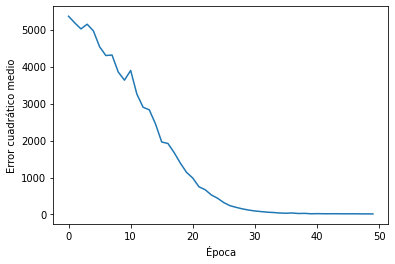

In [ ]:
plt.plot(loss_hist)
plt.xlabel(u'Época')
plt.ylabel(u'Error cuadrático medio')
plt.show()

**Conclusión:** Con una tasa de aprendizaje pequeña el error cuadrático medio desciende mucho más lento por época, por lo que requiere de un mayor número de épocas para que llegue a un valor aceptable.


#### Incrementar la tasa de aprendizaje, aumentar el número de épocas y mantener número de neuronas en la capa oculta.
Tasa de aprendizaje $\alpha = 0.5$, número de épocas $= 50$ y número de neuronas en la capa oculta $= 2$.

In [ ]:
model_high, loss_hist = train_model(build_high, epochs=50, lr=0.5, num_neuronas = 2)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=1, bias=True)
)
E00 loss=[185.38]
E01 loss=[ 68.44]
E02 loss=[ 66.70]
E03 loss=[120.39]
E04 loss=[104.63]
E05 loss=[ 79.69]
E06 loss=[ 66.59]
E07 loss=[103.38]
E08 loss=[220.08]
E09 loss=[151.50]
E10 loss=[124.81]
E11 loss=[120.50]
E12 loss=[100.53]
E13 loss=[146.20]
E14 loss=[ 76.44]
E15 loss=[ 75.05]
E16 loss=[162.38]
E17 loss=[244.86]
E18 loss=[ 84.13]
E19 loss=[247.86]
E20 loss=[131.77]
E21 loss=[110.00]
E22 loss=[ 99.94]
E23 loss=[105.75]
E24 loss=[104.42]
E25 loss=[140.02]
E26 loss=[207.23]
E27 loss=[ 94.81]
E28 loss=[ 75.56]
E29 loss=[ 96.38]
E30 loss=[ 84.89]
E31 loss=[ 69.42]
E32 loss=[ 88.91]
E33 loss=[177.05]
E34 loss=[ 86.25]
E35 loss=[128.31]
E36 loss=[ 93.28]
E37 loss=[139.91]
E38 loss=[159.55]
E39 loss=[108.25]
E40 loss=[ 74.69]
E41 loss=[131.00]
E42 loss=[185.58]
E43 loss=[104.88]
E44 loss=[202.03]
E45 loss=[108.38]
E46 loss=[167.58]
E47 loss=[ 69.

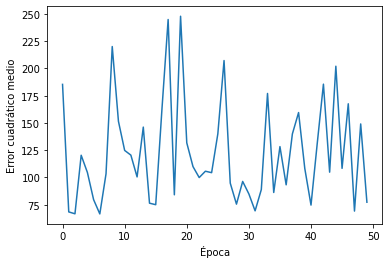

In [ ]:
plt.plot(loss_hist)
plt.xlabel(u'Época')
plt.ylabel(u'Error cuadrático medio')
plt.show()

**Conclusión:** Con una tasa de aprendizaje más grande el error cuadrático medio comienza a diverger, es decir, comienza a decrecer y crecer de manera que el modelo no está aprendiendo.

#### Mantener la tasa de aprendizaje y el número de épocas, pero incrementar el número de neuronas en la capa oculta
Tasa de aprendizaje $\alpha = 0.5$, número de épocas $= 5$ y número de neuronas en la capa oculta $= 50$.

In [ ]:
model_high, loss_hist = train_model(build_high, epochs=5, lr=0.001, num_neuronas = 50)

Sequential(
  (0): Linear(in_features=2, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
E00 loss=[4576.13]
E01 loss=[293.61]
E02 loss=[ 43.81]
E03 loss=[ 33.12]
E04 loss=[ 54.18]


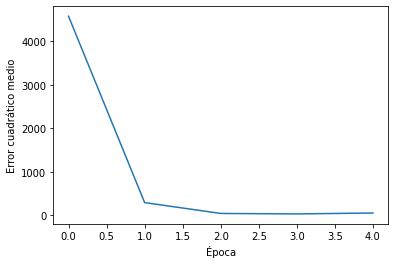

In [ ]:
plt.plot(loss_hist)
plt.xlabel(u'Época')
plt.ylabel(u'Error cuadrático medio')
plt.show()

**Conclusión:** Al incrementar el número de neuronas de la capa oculta también se incrementa el número de parámetros del modelo, por lo que realiza más operaciones por época para entrenar. Además, en este caso se tendría que volver a ajustar la tasa de aprendizaje a un valor más pequeño, ya que se nota que comienza a incrementar la perdida en las últimas épocas.

### Conclusiones generales

La diferencia principal al definir la arquitectura en alto nivel y de medio nivel es que en la de alto nivel se emplea la clase nn.Sequential, la cual es útil para definir capas que van una tras otra de manera rápida, puesto que no hay que declarar algún constructor o el método fordward. Por otro lado definir la arquitectura en medio nivel permite definir a detalle lo que se realiza en el método forward, por ejemplo, se podría emplear múltiples capas con distintas funciones del tipo secuencial conectadas de distintas maneras.

Por otro lado, en cuanto a las distintas configuraciones se observó que es primordial escojer una buena tasa de aprendizaje, ni muy grande ni muy pequeña. La tasa ideal se puede encontrar a través de prueba y error, ya que depende de la complejidad de la red neuronal.  
  
Finalmente, se observa que al incrementar el número de neuronas a 50 en la capa oculta, la pérdida de entrenamiento disminuye de manera deseable. En este caso dicho hiperparámetro no fue tan sensible, puesto que el valor de la pérdida fue muy similar al de 2 neuronas en la capa oculta, sin embargo, en algunos casos puede llegar a ocurrir sobreajuste.